# EAST: An Efficient and Accurate Scene Text Detector

**[Paper](https://arxiv.org/abs/1704.03155v2)**   
**[Github](https://github.com/argman/EAST/)**

## Theory

## Data Preparation

**Dataset ICDAR** : 
- [Text Localization 1: 2013](http://rrc.cvc.uab.es/?ch=2&com=downloads) (not used!)
- [2015](http://rrc.cvc.uab.es/?ch=4&com=introduction)
- [2019](http://rrc.cvc.uab.es/?ch=13)  

**Imaginea Folks** :   
- Use Google Drive Link: https://drive.google.com/drive/folders/1CmEkiDHWQB-miGQRSU3pK7qoAfoifb-R?usp=sharing and download the  files

**Agenta**
- Visulaize the out of data preparation API
- Understand how different imput matrices are prepared namely : `image_mat, score_map_mat, geo_map_mat, training_masks_mat`

- What's unique about data preparation for OCR Text recognition? 
    - Its Text + Image
- All images are provided as JPEG or PNG files and the text files are UTF-8 files with CR/LF new line endings.
- The ground truth is given as separate text files (one per image) where each line specifies the coordinates of one word's bounding box and its transcription in a comma separated format 
- [2015](http://rrc.cvc.uab.es/?ch=4&com=tasks)

img_1.txt <-> gt_img_01.txt

```sh
x1, y1, x2, y2, x3, y3, x4, y4, transcription
```

- [2019](http://rrc.cvc.uab.es/?ch=13&com=tasks)

img_1.txt <-> img_01.txt

```sh
x1_1, y1_1,x2_1,y2_1,x3_1,y3_1,x4_1,y4_1, transcript_1

x1_2,y1_2,x2_2,y2_2,x3_2,y3_2,x4_2,y4_2, transcript_2

x1_3,y1_3,x2_3,y2_3,x3_3,y3_3,x4_3,y4_3, transcript_3
```


In [1]:
import numpy as np
import os
import cv2
import icdar_data as data
import matplotlib.pyplot as plt
%load_ext autoreload

In [2]:
samples = {2015 : [], 2019 : []}

samples[2015] = data.get_images("sample_data/2015/")
samples[2019] = data.get_images("sample_data/2019/")
# samples

Found 20 images
Found 21 images


### 2015 Data

im (512, 512, 3)


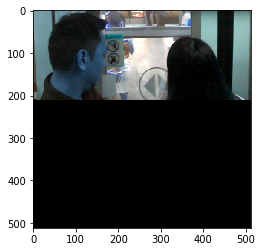

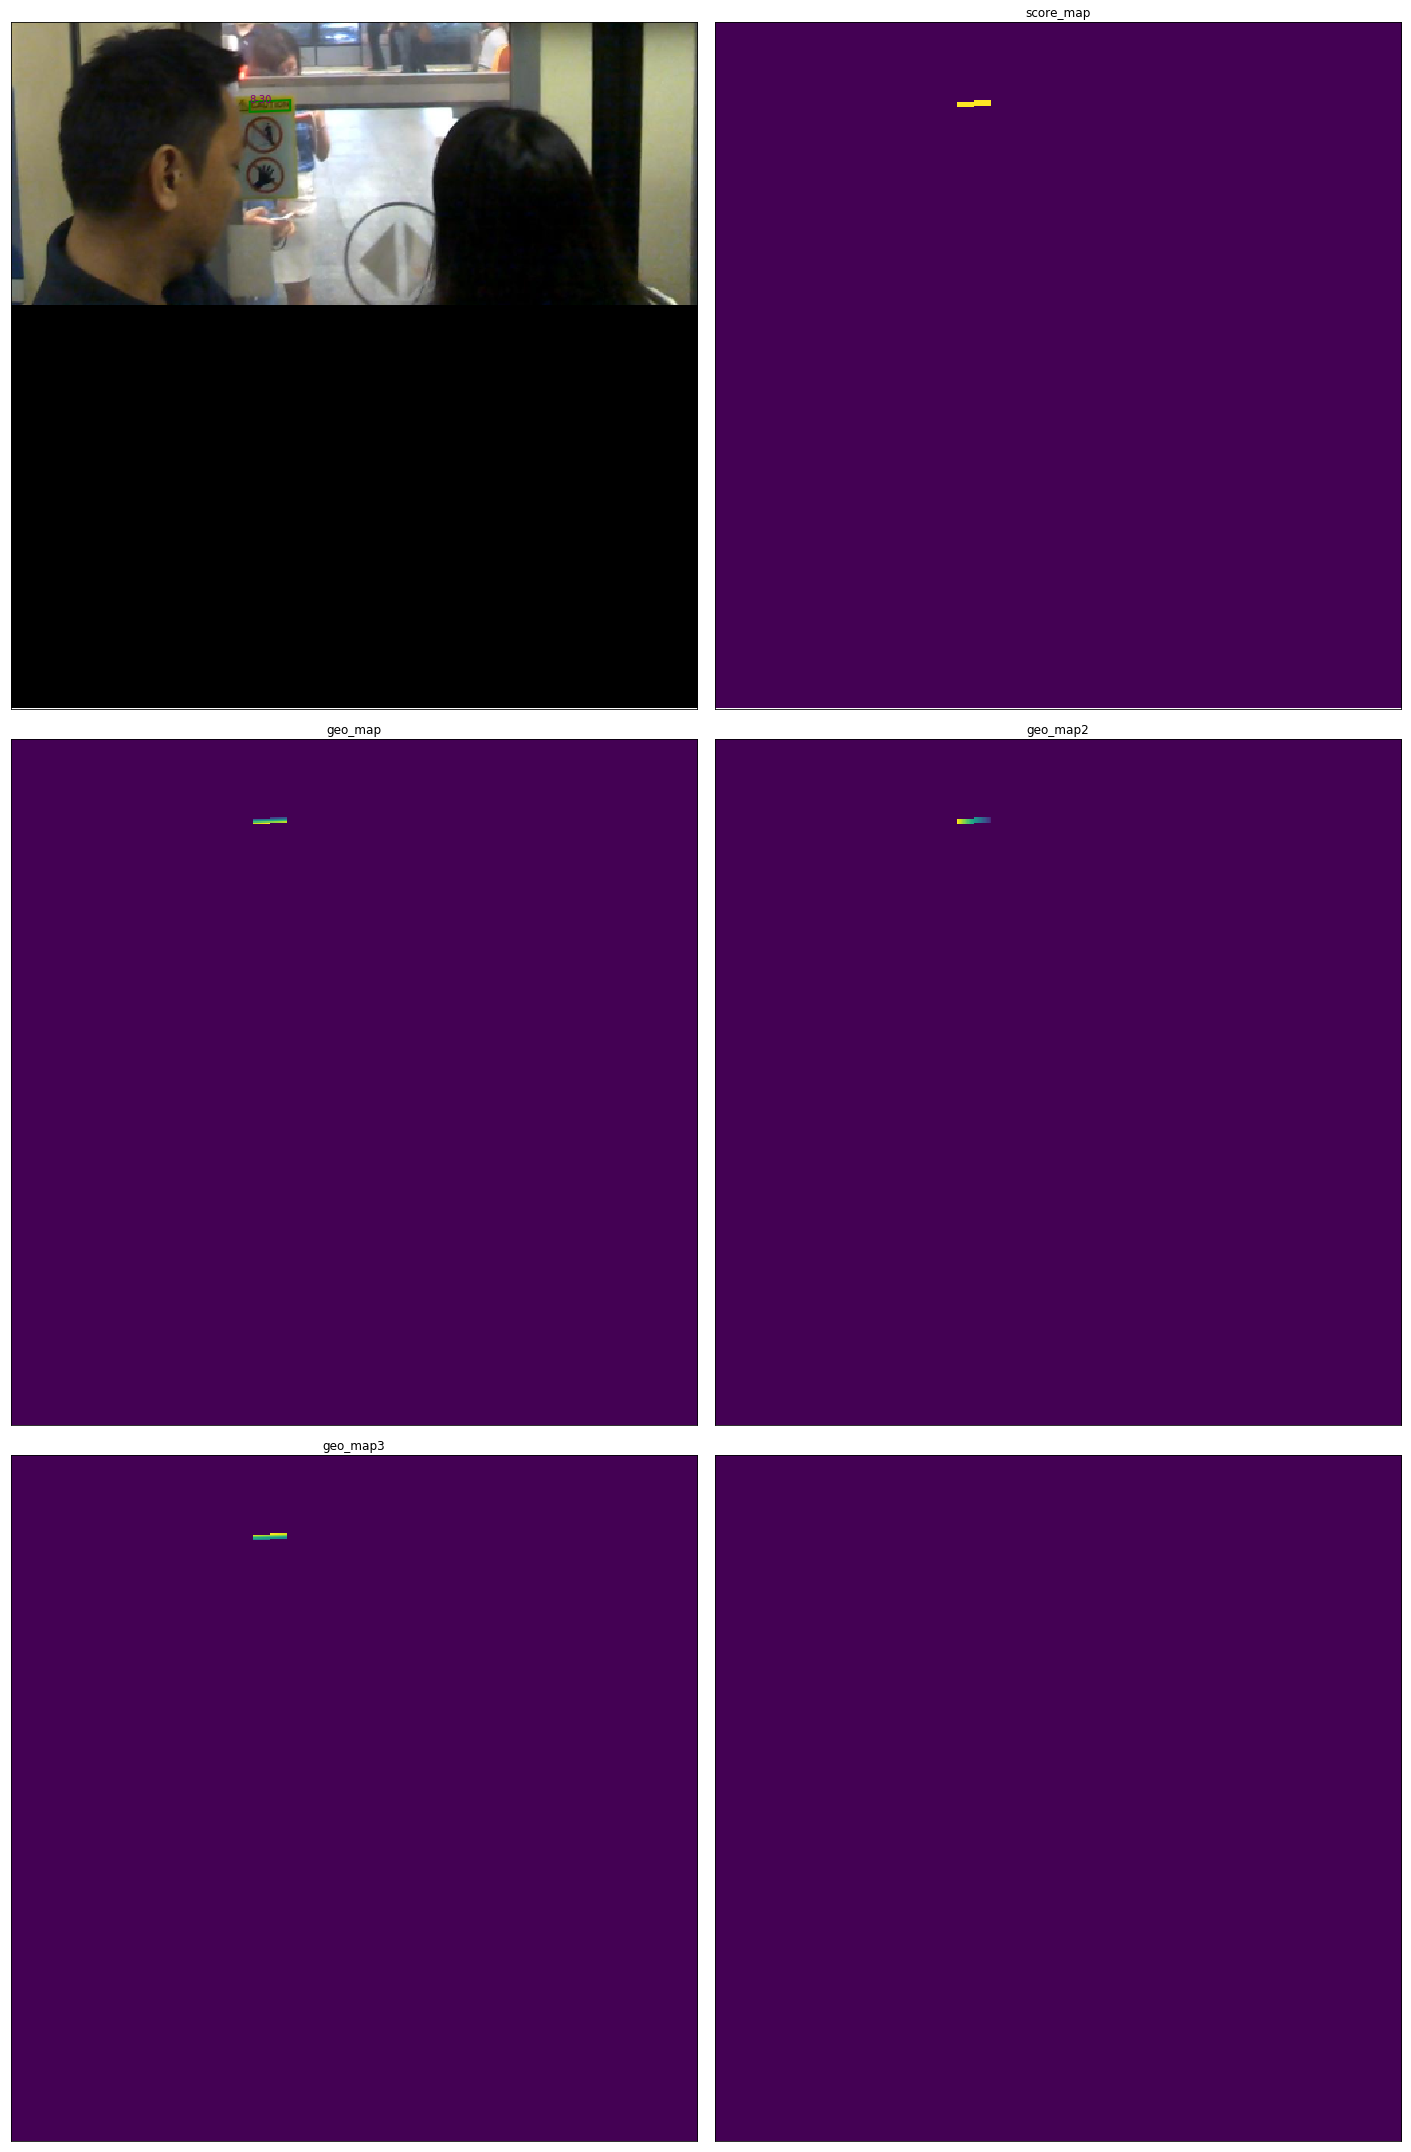

In [3]:
ret = data.image_2_data(image_file_path=samples[2015][0],
                geometry="RBOX",
                min_text_size=1,
                min_crop_side_ratio=0.1,
                input_size=512, 
                background_ratio=3./8,
                random_scale=np.array([0.5, 1, 2.0, 3.0]),
                vis=True)
try:
    image_mat, score_map_mat, geo_map_mat, training_masks_mat = ret
except:
    print("Check the inputs...")

### 2019 Data

im (512, 512, 3)


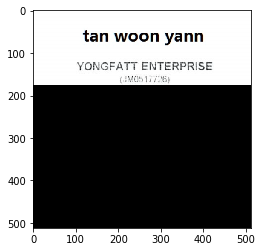

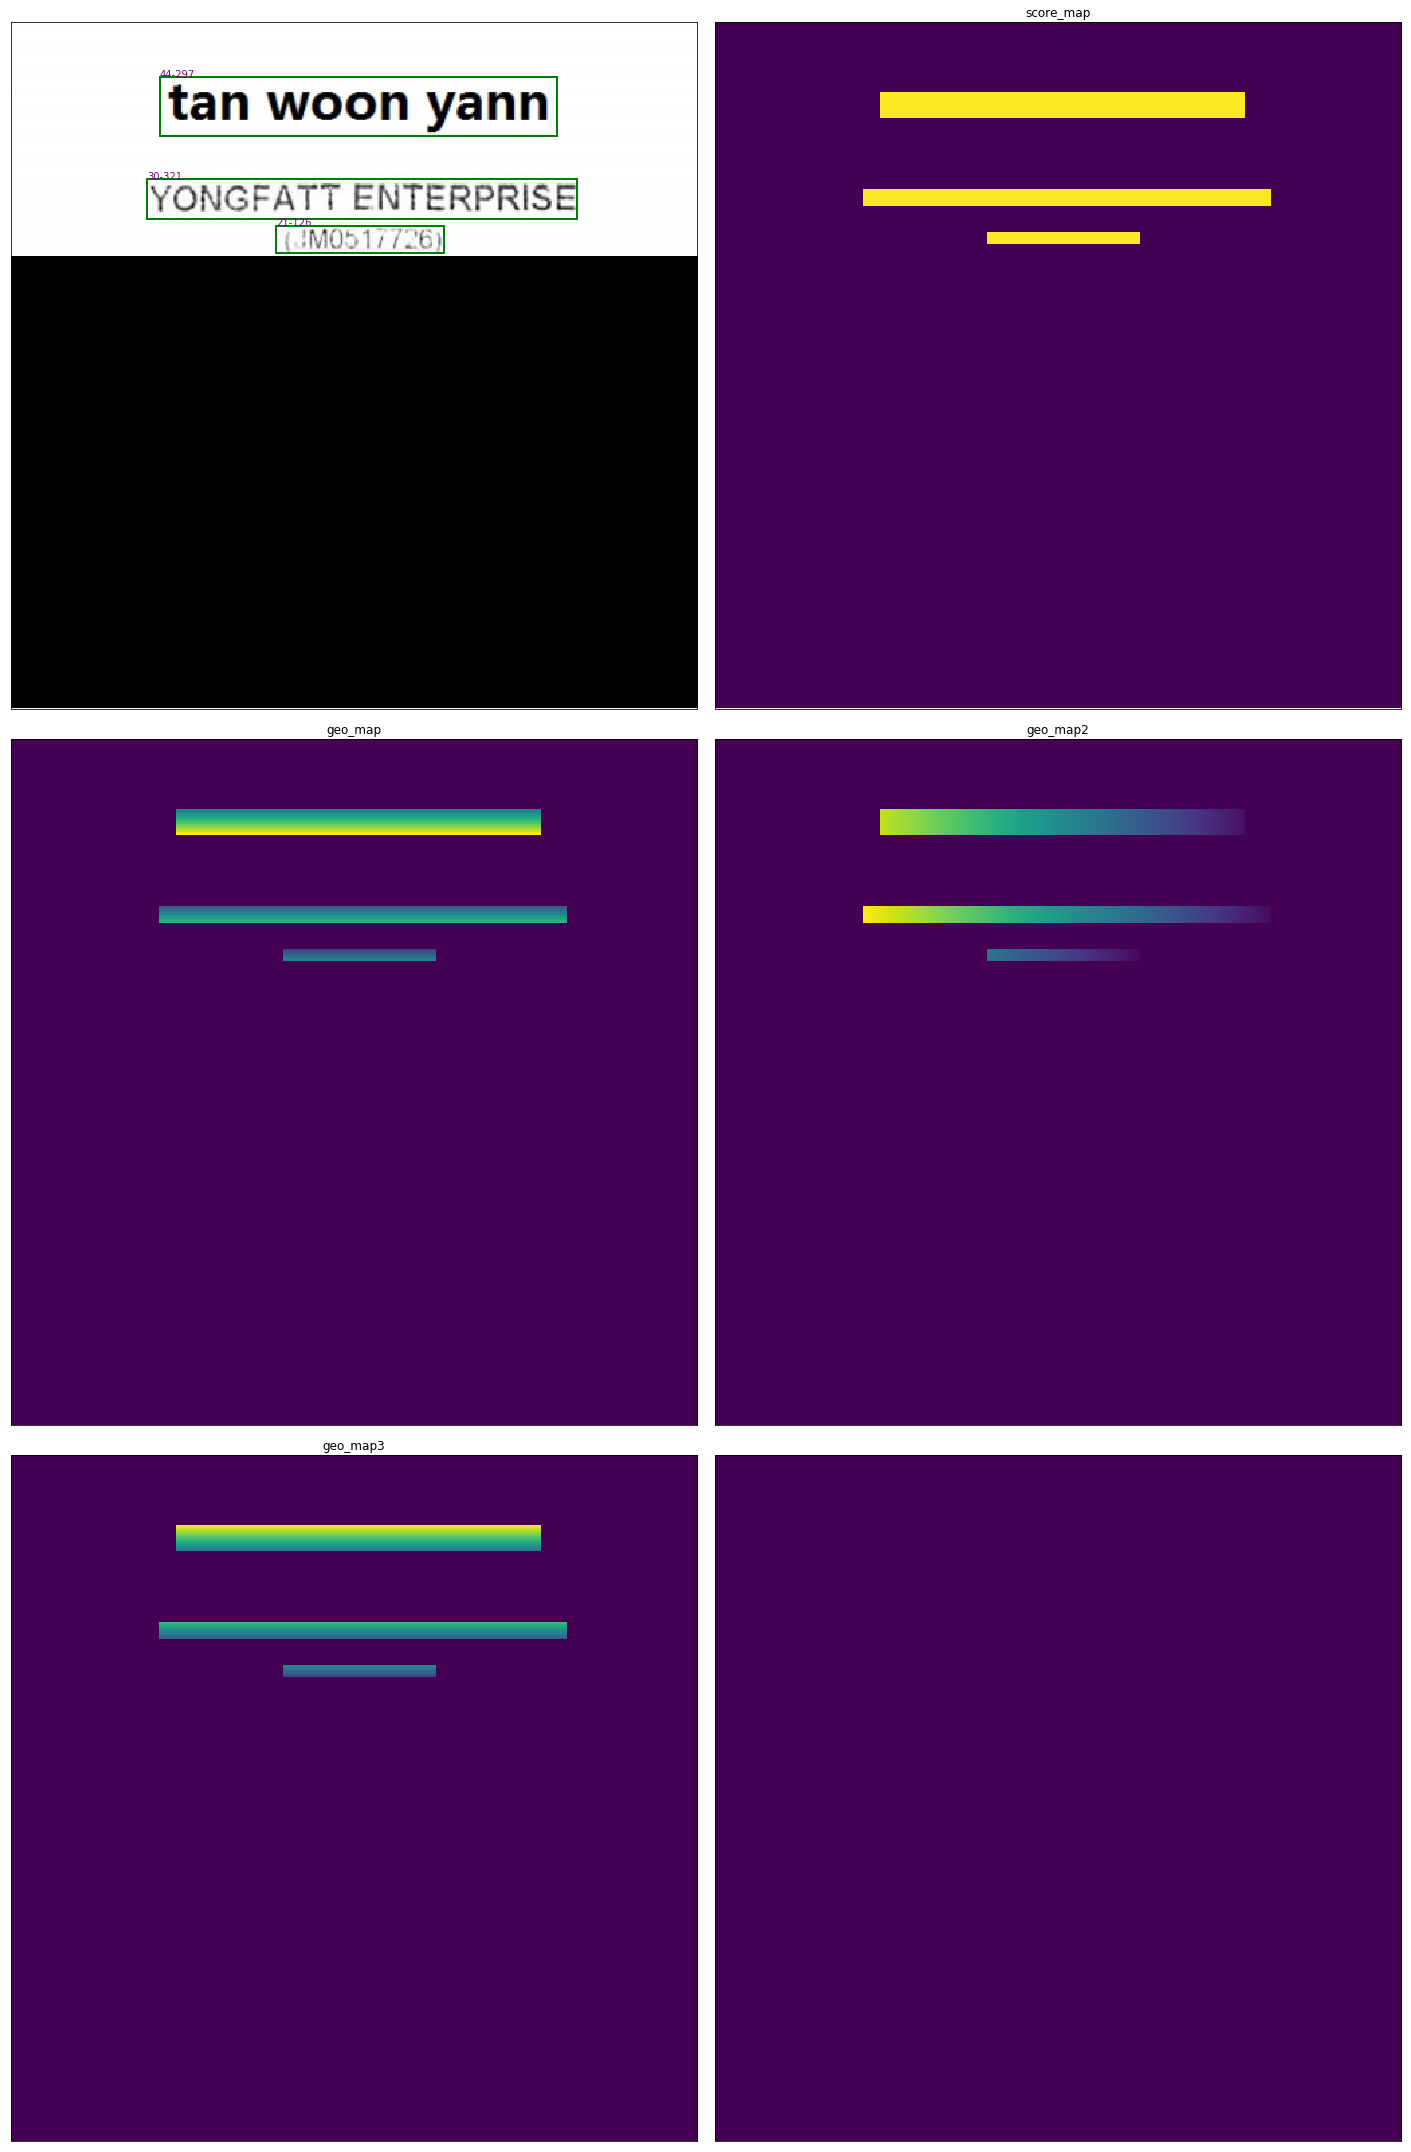

In [4]:
ret = data.image_2_data(image_file_path=samples[2019][0],
                geometry="RBOX",
                min_text_size=1,
                min_crop_side_ratio=0.1,
                input_size=512, 
                background_ratio=3./8,
                random_scale=np.array([0.5, 1, 2.0, 3.0]),
                vis=True)
try:
    image_mat, score_map_mat, geo_map_mat, training_masks_mat = ret
except:
    print("Check the inputs...")

**Steps**

- **Load the image file**

In [5]:
image_file_path=samples[2015][0]
geometry="RBOX"
min_text_size=1
min_crop_side_ratio=0.1
input_size=512
background_ratio=3./8
random_scale=np.array([0.5, 1, 2.0, 3.0])

720 1280


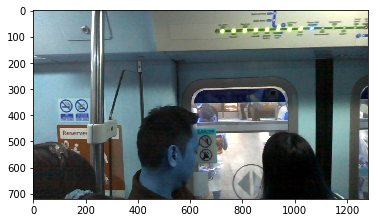

In [6]:
im = cv2.imread(image_file_path)
# print image_file_path
h, w, _ = im.shape
print(h,w)
plt.imshow(im)

- **Load the text annotations as list of array of shape (4,2)**

```
    x1,y1                          x2,y2
    ----------------------------------
    |                                |
    |                                |
    |                                |
    ----------------------------------
    x4,y4                         x3,y3
```
```
     |0 |1 |
    -|--|--|
    0|x1|y1|
    1|x2|y2|
    2|x3|y3|
    3|x4|y4|
```

In [7]:
image_file_path
!cat sample_data/2015/gt_img_6.txt

In [8]:

txt_file_name = image_file_path.replace(os.path.basename(image_file_path).split('.')[1], 'txt')
txt_file_name = txt_file_name.replace(os.path.basename(txt_file_name).split('.')[0], 'gt_' + os.path.basename(txt_file_name).split('.')[0])
print(txt_file_name)
text_polys, text_tags = data.load_annoataion(txt_file_path=txt_file_name)
text_polys[0], text_tags

sample_data/2015/gt_img_6.txt


(array([[875.,  92.],
        [910.,  92.],
        [910., 112.],
        [875., 112.]], dtype=float32),
 array([ True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]))

- **Check and validate the ploygons**
- https://en.wikipedia.org/wiki/Shoelace_formula
- https://math.stackexchange.com/questions/1259094/coordinate-geometry-area-of-a-quadrilateral

In [9]:
# poly = np.array([[875.,  92.],
#         [910.,  92.],
#         [910., 112.],
#         [875., 112.]])
poly = np.array([(5,3),(6,-4),(-3,-2),(-4,7)])
p_area = data.polygon_area(poly)
print("Area:", abs(p_area))


Area: 69.0


In [10]:
text_polys.shape

(20, 4, 2)

In [11]:
text_polys, text_tags = data.check_and_validate_polys(text_polys, text_tags, (h, w))

 - **Random scaling of image**

In [12]:
print("Size before resizing : ", h,w)
rd_scale = np.random.choice(random_scale)
im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
text_polys *= rd_scale

Size before resizing :  720 1280


720 1280


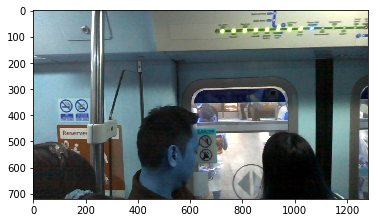

In [13]:
h, w, _ = im.shape
print(h,w)
plt.imshow(im)

 - **Crop Area**

In [14]:
im, text_polys, text_tags = data.crop_area(im, 
                                           text_polys, 
                                           text_tags,
                                           min_crop_side_ratio=min_crop_side_ratio,
                                           crop_background=False)

404 936


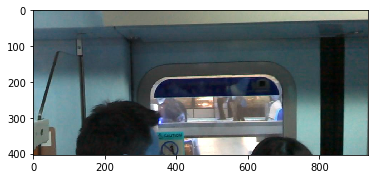

In [15]:
h, w, _ = im.shape
print(h,w)
plt.imshow(im)